In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import re
import string
import nltk
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , GridSearchCV
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier

nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
import joblib

[nltk_data] Downloading package stopwords to C:\Users\Hussaini
[nltk_data]     Enterprises\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Load Dataset
# emotion = pd.read_csv('/content/drive/MyDrive/ML_Project/emotions.csv')
# toxic = pd.read_csv('/content/drive/MyDrive/ML_Project/Toxic_Train.csv')

emotion = pd.read_csv('emotions.csv')
toxic = pd.read_csv('Toxic_Train.csv')

print(emotion.head())
print(toxic.head())



stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # remove mentions/hashtags
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = ' '.join(word for word in text.split() if word not in stop_words)  # remove stopwords
    return text

label_names = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}# for Emotion dataset

X = emotion['text'].apply(clean_text)

y = emotion['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# TF-IDF instead of CountVectorizer\
tfidf_emotion = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf_emotion.fit_transform(X_train)
X_test_tfidf = tfidf_emotion.transform(X_test)

                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0     

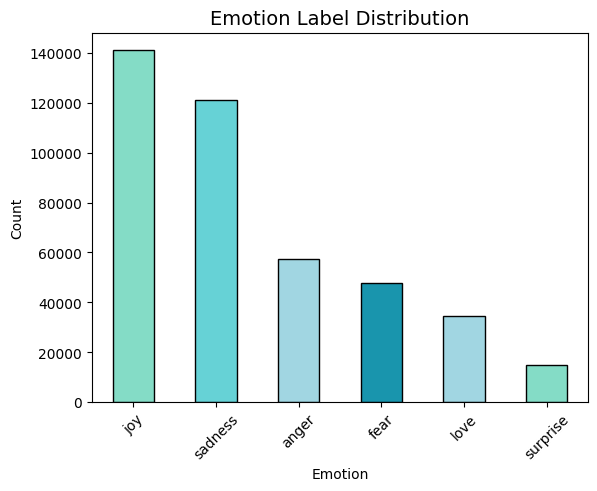

In [11]:
custom_colors = ['#84DCC6', '#66D2D6', '#A1D6E2', '#1995AD', '#A1D6E2']
emotion['label'].map({0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}).value_counts().plot(
    kind='bar',
    color=custom_colors,
    edgecolor='black'
)

plt.title('Emotion Label Distribution', fontsize=14)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

###  Train  Model


In [4]:
emotion_model_nn = MLPClassifier(
    hidden_layer_sizes=(128, 64),   # Two hidden layers
    activation='relu',
    solver='adam',
    max_iter=20,                   
    random_state=42,
    verbose=True
)

emotion_model_nn.fit(X_train_tfidf, y_train)
with open('emotion_model_nn.pkl', "wb") as f:
    pickle.dump(emotion_model_nn, f)

# model_file2 = drive_path + "emotion_vectorizer_Random.pkl"

with open('emotion_vectorizer_nn.pkl', "wb") as f:
    pickle.dump(tfidf_emotion, f)
# 5. Evaluate
y_pred = emotion_model_nn.predict(X_test_tfidf)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

Iteration 1, loss = 0.27845624
Iteration 2, loss = 0.14151592
Iteration 3, loss = 0.11935661
Iteration 4, loss = 0.10546845
Iteration 5, loss = 0.09611451
Iteration 6, loss = 0.08929809
Iteration 7, loss = 0.08480147
Iteration 8, loss = 0.08274868
Iteration 9, loss = 0.08127713
Iteration 10, loss = 0.07975890
Iteration 11, loss = 0.07891241
Iteration 12, loss = 0.07809489
Iteration 13, loss = 0.07749462
Iteration 14, loss = 0.07733455
Iteration 15, loss = 0.07641588
Iteration 16, loss = 0.07639758
Iteration 17, loss = 0.07629003
Iteration 18, loss = 0.07541988
Iteration 19, loss = 0.07487567
Iteration 20, loss = 0.07487855


c:\Program Files\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


0.888882224514767
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     24201
           1       0.90      0.93      0.92     28164
           2       0.78      0.68      0.73      6929
           3       0.90      0.89      0.90     11441
           4       0.81      0.86      0.84      9594
           5       0.74      0.62      0.67      3033

    accuracy                           0.89     83362
   macro avg       0.85      0.82      0.83     83362
weighted avg       0.89      0.89      0.89     83362



### Toxic Word Classifier Using XGboost

In [ ]:
X_train_t = toxic['comment_text'].apply(clean_text)
y_train_t = toxic[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

# X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_toxic, y_toxic, test_size=0.2, random_state=42)


toxic_test = pd.read_csv('Toxic_Test.csv')

X_test_t =  toxic_test['comment_text'].apply(clean_text)
y_test_t = toxic_test[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

# TF-IDF for Toxic Model
tfidf_toxic = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_t_tfidf = tfidf_toxic.fit_transform(X_train_t)
X_test_t_tfidf = tfidf_toxic.transform(X_test_t)


# XGBoost Model
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False
)

multi_xgb = MultiOutputClassifier(xgb)
multi_xgb.fit(X_train_t_tfidf, y_train_t)


# Evaluate Toxic Model
y_pred_t = multi_xgb.predict(X_test_t_tfidf)
print("\nToxic Model Evaluation:")
for i, col in enumerate(y_test_t.columns):
    print(f"\nLabel: {col}")
    print(classification_report(y_test_t[col], y_pred_t[:, i]))

# Save Model and Vectorizer
# joblib.dump(multi_xgb, "/content/drive/MyDrive/ML_Project/toxic_model.pkl")
# joblib.dump(tfidf_toxic, "/content/drive/MyDrive/ML_Project/toxic_vectorizer.pkl")


joblib.dump(multi_xgb, "toxic_model.pkl")
joblib.dump(tfidf_toxic, "toxic_vectorizer.pkl")



In [2]:
def analyze_text(text):
    # Emotion
    emotion_tfidf = tfidf_emotion.transform([text])
    emotion_pred = svm_emotion.predict(emotion_tfidf)[0]
    emotion_result = emotion_labels[int(emotion_pred)]

    # Toxic
    toxic_tfidf = tfidf_toxic.transform([text])
    toxic_pred = multi_xgb.predict(toxic_tfidf)[0]
    toxic_result = [label for label, val in zip(toxic_labels, toxic_pred) if val == 1]

    if not toxic_result:
        toxic_result = ["Not Toxic"]

    return {
        "Emotion": emotion_result,
        "Toxic_Labels": toxic_result
    }








# Load both models and vectorizers
# svm_emotion = joblib.load("/content/drive/MyDrive/ML_Project/emotion_model_cuml.pkl")
# tfidf_emotion = joblib.load("/content/drive/MyDrive/ML_Project/emotion_vectorizer.pkl")
# multi_xgb = joblib.load("/content/drive/MyDrive/ML_Project/toxic_model.pkl")
# tfidf_toxic = joblib.load("/content/drive/MyDrive/ML_Project/toxic_vectorizer.pkl")


svm_emotion = joblib.load("emotion_model_nn.pkl")
tfidf_emotion = joblib.load("emotion_vectorizer_nn.pkl")
multi_xgb = joblib.load("toxic_model.pkl")
tfidf_toxic = joblib.load("toxic_vectorizer.pkl")


emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
toxic_labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']



c:\Program Files\Python313\Lib\pickle.py:1760: UserWarning: [17:51:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\data\../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)
c:\Program Files\Python313\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MultiOutputClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Program Files\P

In [3]:
while True:
    text = input("\nEnter a sentence (or 'quit' to stop): ")
    if text.lower() == 'quit':
        break
    result = analyze_text(text)

    print(f"\nYour Sentence is :{text}")
    print("Predicted Emotion:", result['Emotion'])
    print("Toxic Categories:", ", ".join(result['Toxic_Labels']))


Your Sentence is :i am happy
Predicted Emotion: joy
Toxic Categories: Not Toxic


### Some Example Real Life


Sentence	                                                     Expected Emotion            	Expected Toxic Category
 I’m so happy today, everything feels amazing!                      	joy	                        non-toxic
 I can’t believe you did that… I’m really disappointed.	                sadness                 	non-toxic
 
 I hope something terrible happens to you.	                            anger	                    toxic, threat, severe_toxic